# Clasificador de reseñas

- **Joan Pedro Bruxola**
- **Julio García Bustos**
- **Marcos Rosique Martínez**
- **Mario Soto Ramos**

Primero importamos todas las librerías importantes

In [ ]:
!pip install selenium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.2/499.2 kB 24.9 MB/s eta 0:00:00


In [ ]:
!pip install webdriver_manager

In [ ]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 15.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=bd7828cfae1381a5b733d11fcd2d26c9b3f51f03b630f10a7f4980f48b84c2ce
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


In [25]:
import numpy as np
import pandas as pd
import requests
import re

from collections import Counter
from wordcloud import WordCloud

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options

from bs4 import BeautifulSoup
import time
from langdetect import detect, LangDetectException
import spacy
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

## Extracción de URLs

### URLs de las películas

In [ ]:
# Páginas específicas a scrapear
paginas_objetivo = [1,2,3,365,366]

# Número de películas a extraer de cada página
n_por_pagina = 24

# URL base
url = "https://www.metacritic.com/browse/movie/"

# Cabecera para evitar bloqueo
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36"
}

# Lista para almacenar todos los enlaces
link_list = []

# Iterar por las páginas deseadas
for page in paginas_objetivo:
    print(f"\nAccediendo a página {page}...")

    params = {
        "releaseYearMin": 1990,
        "releaseYearMax": 2014,
        "page": page
    }

    response = requests.get(url, headers=headers, params=params)

    if response.status_code != 200:
        print(f"Error al acceder a la página {page}.")
        continue

    soup = BeautifulSoup(response.content, "html.parser")

    movie_links = soup.find_all("a", class_="c-finderProductCard_container g-color-gray80 u-grid")

    if not movie_links:
        print("No se encontraron películas en esta página.")
        continue

    # Limitar a las primeras `n_por_pagina` películas
    for idx, link in enumerate(movie_links[:n_por_pagina]):
        href = link.get("href")
        if href:
            full_url = f"https://www.metacritic.com{href}"
            link_list.append(full_url)
            print(f"[Pág. {page}] Película {idx+1}: {full_url}")

    time.sleep(1)  # Pausa entre páginas

# Resultados finales
print(f"\nTotal de enlaces obtenidos: {len(link_list)}")


Accediendo a página 1...
[Pág. 1] Película 1: https://www.metacritic.com/movie/dekalog-1988/
[Pág. 1] Película 2: https://www.metacritic.com/movie/boyhood/
[Pág. 1] Película 3: https://www.metacritic.com/movie/three-colors-red/
[Pág. 1] Película 4: https://www.metacritic.com/movie/the-leopard-re-release/
[Pág. 1] Película 5: https://www.metacritic.com/movie/lawrence-of-arabia-re-release/
[Pág. 1] Película 6: https://www.metacritic.com/movie/fanny-and-alexander-re-release/
[Pág. 1] Película 7: https://www.metacritic.com/movie/army-of-shadows/
[Pág. 1] Película 8: https://www.metacritic.com/movie/pepe-le-moko-re-release/
[Pág. 1] Película 9: https://www.metacritic.com/movie/pans-labyrinth/
[Pág. 1] Película 10: https://www.metacritic.com/movie/hoop-dreams/
[Pág. 1] Película 11: https://www.metacritic.com/movie/metropolis-re-release/
[Pág. 1] Película 12: https://www.metacritic.com/movie/rififi-re-release/
[Pág. 1] Película 13: https://www.metacritic.com/movie/4-months-3-weeks-and-2-days

### URLs de las reseñas

In [ ]:
# Definir los filtros y las listas
filters = ['Mixed%20Reviews', 'Negative%20Reviews']

# Lista para almacenar los enlaces
review_links = [f"{link}user-reviews/?filter={filter_type}" for filter_type in filters for link in link_list]
print(f"Tamaño de review_links: {len(review_links)}")

Tamaño de review_links: 240


## Extracción y almacenamiento de reseñas

In [ ]:
def get_user_reviews_selenium(movie_url, max_pages=1, n_res=50):
    chrome_options = Options()
    #chrome_options.add_argument("--headless")  # Ejecutar sin abrir ventana
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("user-agent=Mozilla/5.0")

    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)

    all_reviews = []

    for page in range(max_pages):  # Solo una página por URL
        url = f"{movie_url}&page={page + 1}"  # Se añade la página actual a la URL
        driver.get(url)
        time.sleep(2)  # Espera a que cargue JavaScript

        soup = BeautifulSoup(driver.page_source, "html.parser")

        review_containers = soup.find_all("div", attrs={"data-testid": "product-review"})

        for container in review_containers:
            score_tag = container.find("div", class_="c-siteReviewScore")
            score = score_tag.get_text(strip=True) if score_tag else "No score"

            user_tag = container.find("a", class_="c-siteReviewHeader_username")
            username = user_tag.get_text(strip=True) if user_tag else "No username"

            date_tag = container.find("div", class_="c-siteReviewHeader_reviewDate")
            date = date_tag.get_text(strip=True) if date_tag else "No date"

            quote_tag = container.find("div", class_="c-siteReview_quote")
            review_text = quote_tag.get_text(strip=True) if quote_tag else "No review text"

            all_reviews.append({
                "movie_url": movie_url,  # Añadimos la URL de la película
                "username": username,
                "date": date,
                "score": score,
                "review": review_text
            })

        if len(all_reviews) >= n_res:  # Si ya tenemos n reseñas, salimos del bucle
            break

    driver.quit()
    return all_reviews


# Lista para almacenar todas las reseñas
all_reviews_data = []

# Extraer n reseñas para cada enlace en review_links
for movie_url in review_links:
    print(f"Extrayendo reseñas de: {movie_url}")
    reviews = get_user_reviews_selenium(movie_url, n_res=50)

    # Almacenar las reseñas en la lista
    for review in reviews:
        all_reviews_data.append(review)

# Convertir la lista de reseñas a un DataFrame de pandas
df_reviews = pd.DataFrame(all_reviews_data)

# Mostrar las primeras filas del DataFrame
print(df_reviews.head())

Extrayendo reseñas de: https://www.metacritic.com/movie/dekalog-1988/user-reviews/?filter=Mixed%20Reviews
Extrayendo reseñas de: https://www.metacritic.com/movie/boyhood/user-reviews/?filter=Mixed%20Reviews
Extrayendo reseñas de: https://www.metacritic.com/movie/three-colors-red/user-reviews/?filter=Mixed%20Reviews
Extrayendo reseñas de: https://www.metacritic.com/movie/the-leopard-re-release/user-reviews/?filter=Mixed%20Reviews
Extrayendo reseñas de: https://www.metacritic.com/movie/lawrence-of-arabia-re-release/user-reviews/?filter=Mixed%20Reviews
Extrayendo reseñas de: https://www.metacritic.com/movie/fanny-and-alexander-re-release/user-reviews/?filter=Mixed%20Reviews
Extrayendo reseñas de: https://www.metacritic.com/movie/army-of-shadows/user-reviews/?filter=Mixed%20Reviews
Extrayendo reseñas de: https://www.metacritic.com/movie/pepe-le-moko-re-release/user-reviews/?filter=Mixed%20Reviews
Extrayendo reseñas de: https://www.metacritic.com/movie/pans-labyrinth/user-reviews/?filter=Mi

In [ ]:
# Guardar el DataFrame en un archivo CSV
df_reviews.to_csv("./data/reviews_finales_bad_mixed_only.csv", index=True)

## Preprocesamiento

In [75]:
# Cargar los dos CSV
df1 = pd.read_csv("./data/reviews_finales.csv")
df2 = pd.read_csv("./data/reviews_finales_2.csv")
df3 = pd.read_csv("./data/reviews_finales_3.csv")
df4 = pd.read_csv("./data/reviews_finales_bad_mixed_only.csv")

# Concatenar y resetear índice para evitar duplicados o índices desordenados
df = pd.concat([df1, df2, df3, df4], ignore_index=True)

# Verifica el resultado
print(df.shape)

(9953, 6)


In [76]:
df.head()

,Unnamed: 0,movie_url,username,date,score,review
0,0,https://www.metacritic.com/movie/moonlight-201...,Randomsquirrel,"Jan 15, 2025",10,It was an absolutely brilliant film. Character...
1,1,https://www.metacritic.com/movie/moonlight-201...,isabellacosta8,"Oct 10, 2024",10,[SPOILER ALERT: This review contains spoilers.]
2,2,https://www.metacritic.com/movie/moonlight-201...,Gabrielx593,"Oct 9, 2024",10,[SPOILER ALERT: This review contains spoilers.]
3,3,https://www.metacritic.com/movie/moonlight-201...,NWR1,"Mar 31, 2024",9,I haven’t felt this much emotion in a long tim...
4,4,https://www.metacritic.com/movie/moonlight-201...,Alexmarshall,"Oct 16, 2023",10,Reallyamazing


In [ ]:
df.shape

(9953, 6)

In [77]:
# Devuelve un booleano para cada fila indicando si es duplicada (excepto la primera aparición)
duplicated_rows = df.duplicated()

# Mostrar filas duplicadas
print(df[duplicated_rows])

Empty DataFrame
Columns: [Unnamed: 0, movie_url, username, date, score, review]
Index: []


In [78]:
# Aplicar la extracción y transformación del nombre de la película a la columna "movie_url"
df['movie_url'] = df['movie_url'].apply(lambda x: re.search(r'/movie/([^/]+)', x).group(1).replace('-', ' ').title())

# Renombrar la columna "movie_url" a "movie"
df = df.rename(columns={"movie_url": "movie"})

df.head(5)

,Unnamed: 0,movie,username,date,score,review
0,0,Moonlight 2016,Randomsquirrel,"Jan 15, 2025",10,It was an absolutely brilliant film. Character...
1,1,Moonlight 2016,isabellacosta8,"Oct 10, 2024",10,[SPOILER ALERT: This review contains spoilers.]
2,2,Moonlight 2016,Gabrielx593,"Oct 9, 2024",10,[SPOILER ALERT: This review contains spoilers.]
3,3,Moonlight 2016,NWR1,"Mar 31, 2024",9,I haven’t felt this much emotion in a long tim...
4,4,Moonlight 2016,Alexmarshall,"Oct 16, 2023",10,Reallyamazing


In [79]:
df = df[~df['review'].isna()]

In [80]:
# Función para manejar excepciones y textos vacíos
def safe_detect(text):
    try:
        if text.strip():  # Asegurarse de que el texto no esté vacío
            return detect(text)
        else:
            return None  # Si el texto está vacío, devuelve None
    except LangDetectException:
        return None  # Si no puede detectar el idioma, devuelve None

# Eliminar las filas donde la columna 'review' contiene "SPOILER ALERT" y crear la columna 'sentiment' basada en la columna 'score'
df = (df[~df['review'].str.contains("SPOILER ALERT", case=True, na=False)]
              .assign(language = df['review'].apply(safe_detect)))

# Filtrar el DataFrame para quedarse solo con las filas donde el idioma es 'en'
df = df[df['language'] == 'en']

df = df.drop('language', axis = 1)

df.head(5)

,Unnamed: 0,movie,username,date,score,review
0,0,Moonlight 2016,Randomsquirrel,"Jan 15, 2025",10,It was an absolutely brilliant film. Character...
3,3,Moonlight 2016,NWR1,"Mar 31, 2024",9,I haven’t felt this much emotion in a long tim...
5,5,Moonlight 2016,Youngoth,"Oct 16, 2023",10,"This movie is masterpiece, so well done. Deser..."
6,6,Moonlight 2016,Dominik08,"Aug 15, 2023",8,"A refined production, with no obvious weakness..."
7,7,Moonlight 2016,AgentLvi,"Jun 27, 2023",7,"Decent movie. The story is so --so, scoring is..."


In [81]:
df['sentiment'] = df['score'].apply(lambda x: 'NEG' if x <= 3 else ('NEU' if 4 <= x <= 6 else 'POS'))

df.head(5)

,Unnamed: 0,movie,username,date,score,review,sentiment
0,0,Moonlight 2016,Randomsquirrel,"Jan 15, 2025",10,It was an absolutely brilliant film. Character...,POS
3,3,Moonlight 2016,NWR1,"Mar 31, 2024",9,I haven’t felt this much emotion in a long tim...,POS
5,5,Moonlight 2016,Youngoth,"Oct 16, 2023",10,"This movie is masterpiece, so well done. Deser...",POS
6,6,Moonlight 2016,Dominik08,"Aug 15, 2023",8,"A refined production, with no obvious weakness...",POS
7,7,Moonlight 2016,AgentLvi,"Jun 27, 2023",7,"Decent movie. The story is so --so, scoring is...",POS


In [82]:
df.shape

(8698, 7)

Instalación del modelo de spaCy

Para instalar el modelo `en_core_web_md` de **spaCy**, ejecuta el siguiente comando en tu **Anaconda Prompt** o **Terminal**:

```bash
python -m spacy download en_core_web_md


In [ ]:
!python -m spacy download en_core_web_md


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 44.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [83]:
nlp = spacy.load('en_core_web_md')

In [84]:
from spacy.lang.en.stop_words import STOP_WORDS
print(STOP_WORDS)

{'three', 'off', 'keep', 'another', '’ve', 'seeming', 'hundred', 'here', 'this', 'seem', "n't", 'not', 'via', 'elsewhere', 'her', 'will', 'also', 'done', 'anyhow', 'whose', 'its', 'whence', 'beforehand', 'part', 'when', 'doing', 'everywhere', 'might', 'often', 'other', 'we', 'him', 'most', 'she', 'himself', 'besides', 'too', 'through', 'whither', 'mine', 'you', '’s', 'really', 'somehow', 'hereafter', 'either', 'except', 'your', 'per', 'n‘t', 'noone', 'mostly', 'ourselves', 'back', 'namely', 'only', '‘re', 'onto', 'from', 'eleven', 'something', 'and', 'everyone', 'all', 'up', 'well', 'towards', 'throughout', 'since', 'unless', 'no', 'down', 'call', 'should', 'thus', 'sixty', 'whereupon', 'eight', 'yet', 'a', 'show', 'some', "'m", 'an', 'may', 'under', 'that', 'hereby', 'perhaps', 'it', 'side', '’d', '‘m', 'go', "'d", 'are', 'twelve', 'without', 'hence', 'between', 'thereafter', 'so', 'two', 'therein', 'due', 'now', 'whoever', 'though', '‘ll', 'anywhere', 'than', '’ll', 'what', 'with', '

Podemos calcular un porcentaje de stopwords para cada clase, para ver directamente la influencia de ellos en el texto.

In [85]:
# función para calcular el porcentaje de stopwords en un texto
def stopword_percentage(tokens):
    stopword_count = sum(1 for word in tokens if word in STOP_WORDS)
    stopword_pct = (stopword_count / len(tokens)) * 100
    return stopword_pct

# Función para limpiar, tokenizar y lematizar
def process_text_column2(df, text_column):

    df['stopword_percentage'] = df[text_column].apply(stopword_percentage)
    return df

def graphics_stopwords(df, text_column):

    stopwords_by_rating = df.groupby(text_column)['stopword_percentage'].mean()
    meaningful_by_rating = 100 - stopwords_by_rating

    plt.figure(figsize=(8, 6))
    bar1 = plt.bar(stopwords_by_rating.index, stopwords_by_rating, color='#2C77A8', label='Stopwords')
    bar2 = plt.bar(meaningful_by_rating.index, meaningful_by_rating, bottom=stopwords_by_rating, color='#87CEEB', label='Palabras con significado')

    plt.xlabel(text_column)
    plt.ylabel('Porcentaje')
    plt.title('Porcentaje de stopwords vs. con significado')
    plt.xticks(stopwords_by_rating.index)
    plt.legend()
    plt.show()

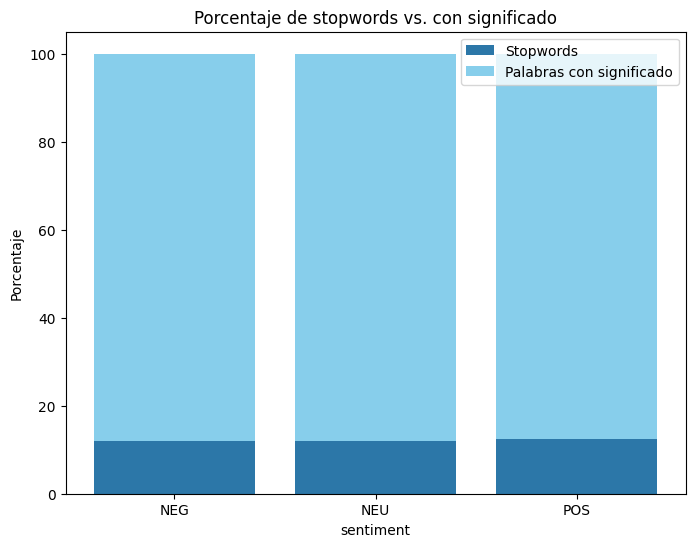

In [86]:
process_text_column2(df, 'review')
graphics_stopwords(df, 'sentiment')

Podemos ver como el porcentaje de stopwords es de alrededor del 15%

In [87]:
# Definir el patrón para los caracteres especiales
pat = '[{}]'.format(re.escape(string.punctuation))

# Definir la función para normalizar, lematizar y eliminar puntuación
def normalize_document_remove_punct(doc):

    doc = re.sub(r'\d+', '', doc)
    # Separamos en tokens
    tokens = nlp(doc)

    # Quitamos puntuación, espacios y stopwords, y aplicamos lematización
    filtered_tokens = [re.sub(pat, ' ', t.lemma_.lower())  # Usamos t.lemma_ para lematizar
                       for t in tokens
                       if not t.is_stop        # Eliminar stopwords
                       and not t.is_punct      # Eliminar puntuación
                       and not t.is_space]      # Eliminar espacios]

    # Juntamos de nuevo en una cadena
    doc = ' '.join(filtered_tokens)

    return doc

# Aplicar la función a cada elemento de la columna 'contenido' tanto en treino como en test
df['review'] = df['review'].apply(normalize_document_remove_punct)

df.head(5)

,Unnamed: 0,movie,username,date,score,review,sentiment,stopword_percentage
0,0,Moonlight 2016,Randomsquirrel,"Jan 15, 2025",10,absolutely brilliant film character deep plot ...,POS,16.875000
3,3,Moonlight 2016,NWR1,"Mar 31, 2024",9,feel emotion long time chiron manifest emotion...,POS,12.867647
5,5,Moonlight 2016,Youngoth,"Oct 16, 2023",10,movie masterpiece deserve oscar,POS,10.294118
6,6,Moonlight 2016,Dominik08,"Aug 15, 2023",8,refined production obvious weakness base ratio...,POS,13.333333
7,7,Moonlight 2016,AgentLvi,"Jun 27, 2023",7,decent movie story so scoring great visual d...,POS,13.131313


## Exploratorio

Aplicamos una tokenización a los datos, para separar las palabras que tenemos en tokens para poder estudiarlo de manera clara y concisa.

In [ ]:
def process_text_column(df, text_column, lemmatizer=None):
    df['tokens'] = df[text_column].apply(nlp)
    return df

In [ ]:
process_text_column(df, "review")

,Unnamed: 0,movie,username,date,score,review,sentiment,stopword_percentage,tokens
0,0,Moonlight 2016,Randomsquirrel,"Jan 15, 2025",10,absolutely brilliant film character deep plot ...,POS,16.875000,"(absolutely, brilliant, film, character, deep,..."
3,3,Moonlight 2016,NWR1,"Mar 31, 2024",9,feel emotion long time chiron manifest emotion...,POS,12.867647,"(feel, emotion, long, time, chiron, manifest, ..."
5,5,Moonlight 2016,Youngoth,"Oct 16, 2023",10,movie masterpiece deserve oscar,POS,10.294118,"(movie, masterpiece, deserve, oscar)"
6,6,Moonlight 2016,Dominik08,"Aug 15, 2023",8,refined production obvious weakness base ratio...,POS,13.333333,"(refined, production, obvious, weakness, base,..."
7,7,Moonlight 2016,AgentLvi,"Jun 27, 2023",7,decent movie story so scoring great visual d...,POS,13.131313,"(decent, movie, story, , so, scoring, great,..."
...,...,...,...,...,...,...,...,...,...
9948,1365,The Hottie The Nottie,Annoymous1,"May 3, 2013",0,fun laugh excellent award garbage get razzie b...,NEG,15.264798,"(fun, laugh, excellent, award, garbage, get, r..."
9949,1366,The Hottie The Nottie,snowcold,"Dec 5, 2011",1,let paris hilton bikini bright spot movie bori...,NEG,13.375796,"(let, paris, hilton, bikini, bright, spot, mov..."
9950,1367,The Hottie The Nottie,Kadeemluvmusic,"Aug 20, 2011",0,time paris hilton carls jr start make porno m...,NEG,10.765550,"(time, paris, hilton, carls, jr, , start, mak..."
9951,1368,The Hottie The Nottie,smijatov,"Dec 22, 2010",1,film easily fit bad time category ah painful w...,NEG,11.637931,"(film, easily, fit, bad, time, category, ah, p..."


Podemos graficar la distribución de longitud de textos para cada clase.

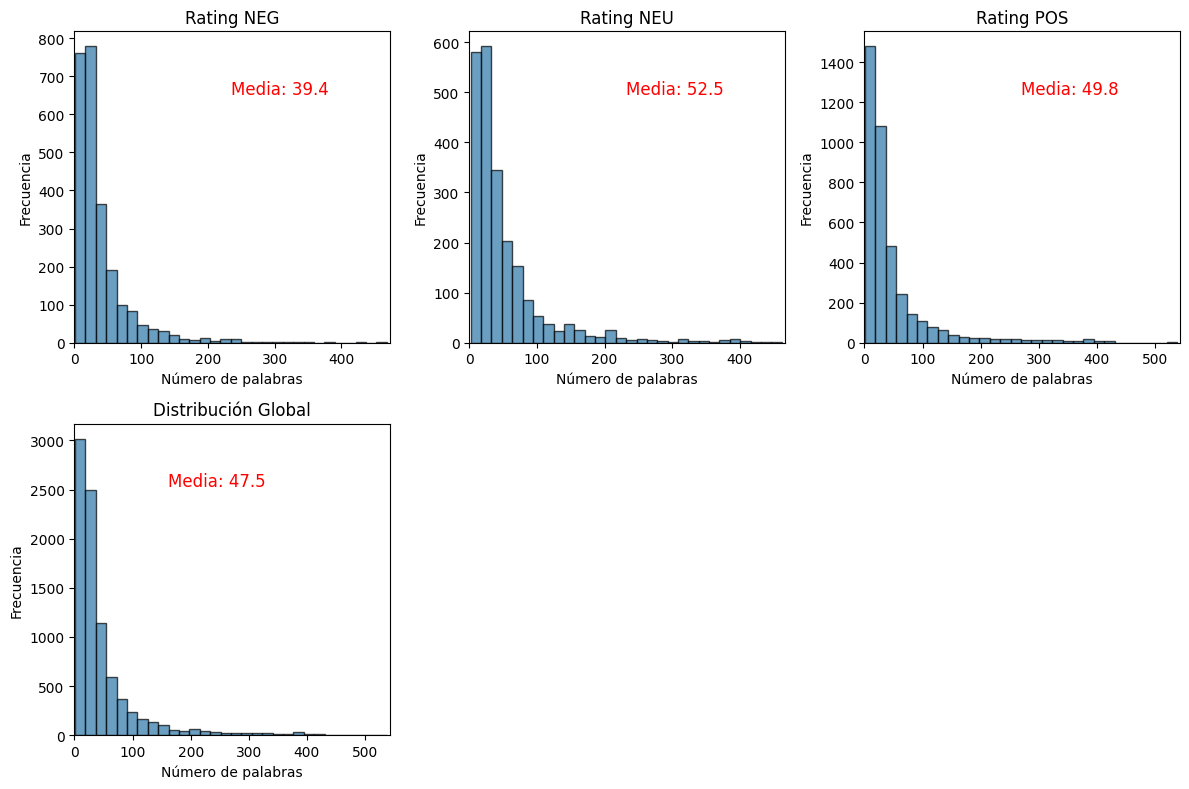

In [ ]:
def graficar_longitud_textos(df, text_column, rating_column):
    df['NP'] = df[text_column].apply(len)

    ratings = sorted(df[rating_column].unique())
    num_ratings = len(ratings)
    num_cols = min(3, num_ratings + 1)
    num_rows = (num_ratings + 1 + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows))
    axes = np.ravel(axes)

    for i, rating in enumerate(ratings):
        ax = axes[i]
        subset = df[df[rating_column] == rating]
        media_np = subset['NP'].mean()
        max_np = subset['NP'].max()

        ax.hist(subset['NP'], bins=30, edgecolor='black', alpha=0.7, color='#2C77A8')
        ax.set_xlim(0, max_np + 5)  # Añadimos un margen para mejor visualización
        ax.set_xlabel('Número de palabras')
        ax.set_ylabel('Frecuencia')
        ax.set_title(f'Rating {rating}')

        ax.text(max_np * 0.5, ax.get_ylim()[1] * 0.8, f'Media: {media_np:.1f}', fontsize=12, color='red')

    # Gráfico global al final
    global_ax = axes[num_ratings]
    media_global = df['NP'].mean()
    max_np_global = df['NP'].max()

    global_ax.hist(df['NP'], bins=30, edgecolor='black', alpha=0.7, color='#2C77A8')
    global_ax.set_xlim(0, max_np_global + 5)
    global_ax.set_xlabel('Número de palabras')
    global_ax.set_ylabel('Frecuencia')
    global_ax.set_title('Distribución Global')
    global_ax.text(max_np_global * 0.3, global_ax.get_ylim()[1] * 0.8, f'Media: {media_global:.1f}', fontsize=12, color='red')

    # Eliminar subplots vacíos si hay
    for j in range(num_ratings + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

graficar_longitud_textos(df, 'tokens', 'sentiment')

Vemos como la mayoría de los textos tienen una longitud parecida para cada clase, la cuál refiere a unas 30-40 palabras por cada reseña, lo cuál nos va a ayudar a saber como se van a aplicar los word embeddings y los distintos modelos a los datos

Para ver las palabras más repetidas por vcada clase obtenemos los wordclouds

In [ ]:
def wordclouds(df, column_partition, top_n):

    # Obtener lista de todas las palabras en el dataset
    all_words = [word for tokens in df['tokens'] for word in tokens]

    # Contar frecuencia de palabras
    word_freq = Counter(all_words)

    # Obtener las `top_n` palabras más comunes
    top_words = {word for word, _ in word_freq.most_common(top_n)}

    # Filtrar los tokens eliminando las palabras más comunes
    df['filtered_tokens'] = df['tokens'].apply(lambda tokens: [word for word in tokens if word not in top_words])

    # Generar WordCloud por cada rating
    ratings = sorted(df[column_partition].unique())
    fig, axes = plt.subplots(1, len(ratings), figsize=(20, 5))

    for i, rating in enumerate(ratings):
        #text = ' '.join([' '.join(tokens) for tokens in df[df[column_partition] == rating]['filtered_tokens']])
        text = ' '.join([' '.join(token.text for token in tokens) for tokens in df[df[column_partition] == rating]['filtered_tokens']])

        wordcloud = WordCloud(width=400, height=400, background_color='white').generate(text)

        # Mostrar en subplot
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].axis('off')
        axes[i].set_title(f'{rating}')

    plt.show()


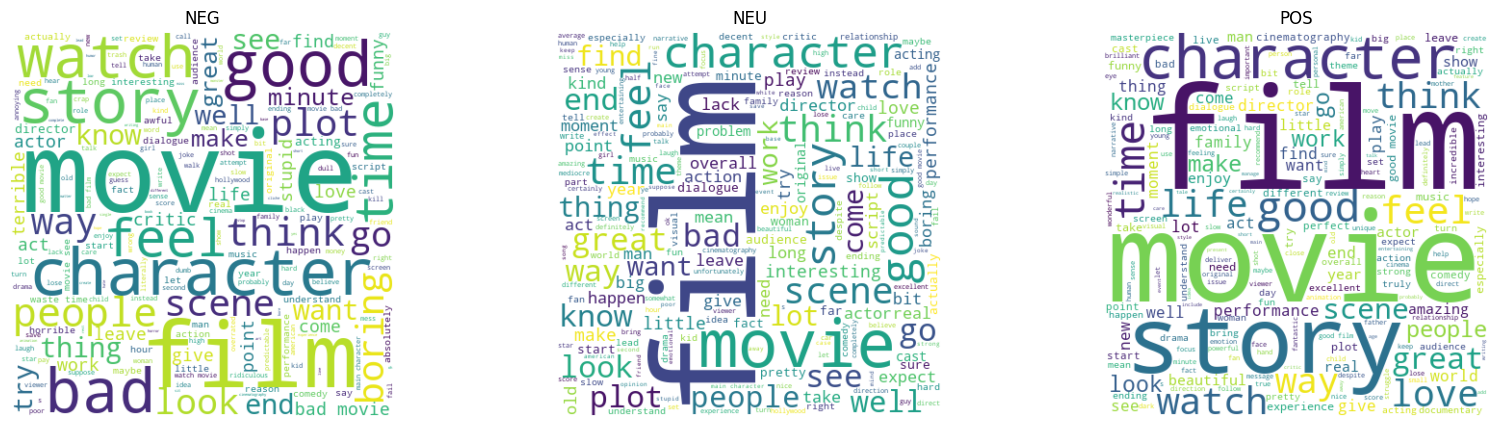

In [ ]:
wordclouds(df, 'sentiment', 50)

Podemos ver como en los wordcloud las palabras que más se repiten naturalmente son "movie" y "film", cosa que tiene sentido. Por otro lado, podemos ver algunas palabras típicas de cada conjunto como "bad", "boring" o "bad movie" en el conjunto negativo. En el conjunto neurtro podemos ver como los comentarios suelen reflejar sobre todo comentarios positivos, seguramente por como se estructuran los textos al querer dar una opinión buena pero que al espectador le haya encantado el todo (verbos como feel, palabras que reflejan la fijación en algo como "character", "scene" o "story" para destacar/pasar por alto solo una parte de todo lo que implica el filme... ). Por último, el grupo del grupo positivo tiene sobre todo verbos/adjetivos positivos, por lo que entendemos que el texto esta bien clasificado y podemos proseguir.

También podemos ver las palabras que mas se repiten

In [ ]:
# Función para obtener n-gramas
def get_ngrams(tokens, n):
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [' '.join(ngram) for ngram in ngrams]

# Función para calcular y graficar bigramas y trigramas más comunes por clases
def plot_most_common_ngrams_by_class(df, text_column, class_column):
    # Crear subgráficos para bigramas
    num_classes = len(df[class_column].unique())
    ncols = 3  # Número de columnas de subgráficos
    nrows = (num_classes + ncols - 1) // ncols  # Calcular número de filas necesarias

    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
    axes = axes.flatten()  # Aplanar la matriz de ejes para facilitar el acceso

    # Generar bigramas
    for i, class_value in enumerate(df[class_column].unique()):

        # Asegúrate de que cada entrada sea una lista de strings
        # Asegúrate de que cada entrada sea una lista de strings
        df['tokens'] = df['tokens'].apply(lambda x: [t.text if hasattr(t, "text") else str(t) for t in x] if isinstance(x, list) else str(x).split())

        # Filtrar los datos por clase
        subset = df[df[class_column] == class_value]

        # Obtener todos los tokens del subset filtrado
        all_words = [word for tokens in subset[text_column] for word in tokens]

        # Calcular bigramas
        bigram_freq = Counter(get_ngrams(all_words, 2))

        # Obtener los 10 bigramas más comunes
        bigram_most_common = bigram_freq.most_common(10)

        # Bigramas
        bigrams, bigram_counts = zip(*bigram_most_common)
        axes[i].barh(bigrams, bigram_counts, color='#a9dfd0', alpha=0.7)

        # Configuración de los gráficos
        axes[i].set_title(f'Bigramas más comunes en {class_value}')
        axes[i].set_xlabel('Frecuencia')
        axes[i].set_ylabel('Bigramas')

    # Ajustar espacio entre subgráficos y mostrar el plot de bigramas
    plt.tight_layout()
    plt.show()

    # Crear subgráficos para trigramas
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
    axes = axes.flatten()  # Aplanar la matriz de ejes para facilitar el acceso

    # Generar trigramas
    for i, class_value in enumerate(df[class_column].unique()):
        # Filtrar los datos por clase
        subset = df[df[class_column] == class_value]

        # Obtener todos los tokens del subset filtrado
        all_words = [word for tokens in subset[text_column] for word in tokens]

        # Calcular trigramas
        trigram_freq = Counter(get_ngrams(all_words, 3))

        # Obtener los 10 trigramas más comunes
        trigram_most_common = trigram_freq.most_common(10)

        # Trigramas
        trigrams, trigram_counts = zip(*trigram_most_common)
        axes[i].barh(trigrams, trigram_counts, color='#2C77A8', alpha=0.7)

        # Configuración de los gráficos
        axes[i].set_title(f'Trigramas más comunes en {class_value}')
        axes[i].set_xlabel('Frecuencia')
        axes[i].set_ylabel('Trigramas')

    # Ajustar espacio entre subgráficos y mostrar el plot de trigramas
    plt.tight_layout()
    plt.show()

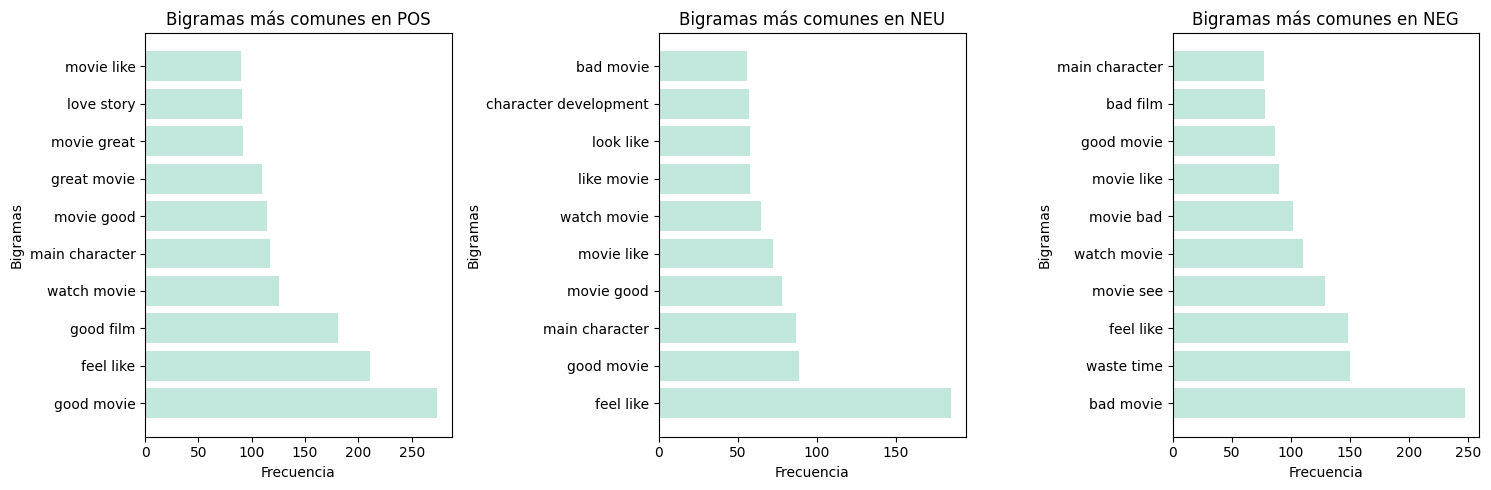

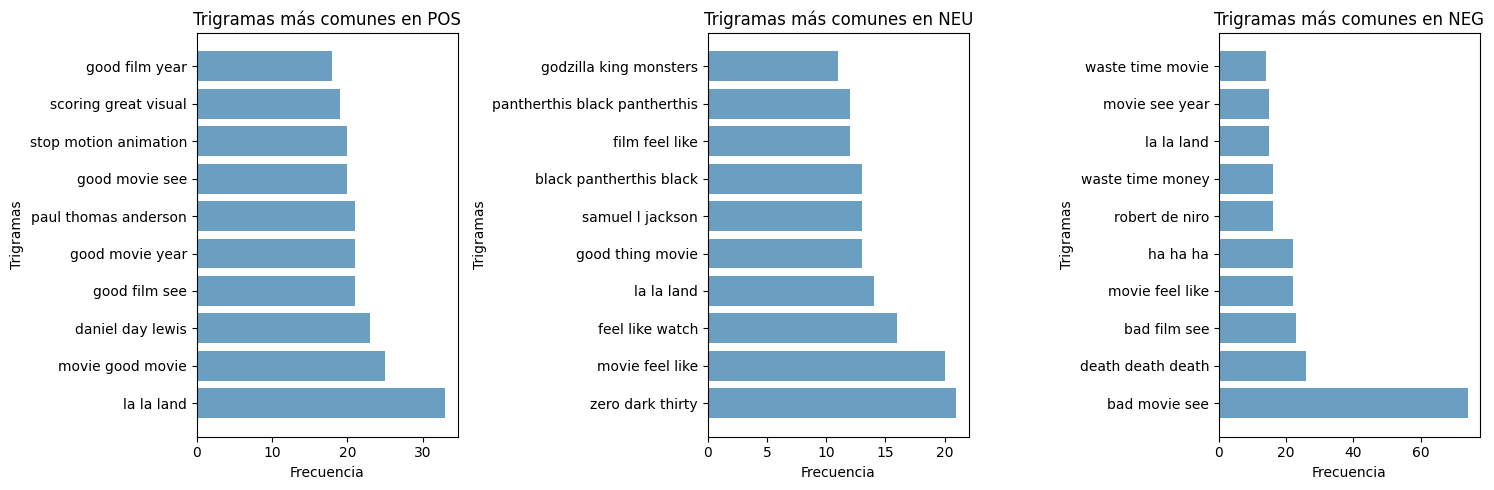

In [ ]:
plot_most_common_ngrams_by_class(df, "tokens", "sentiment")

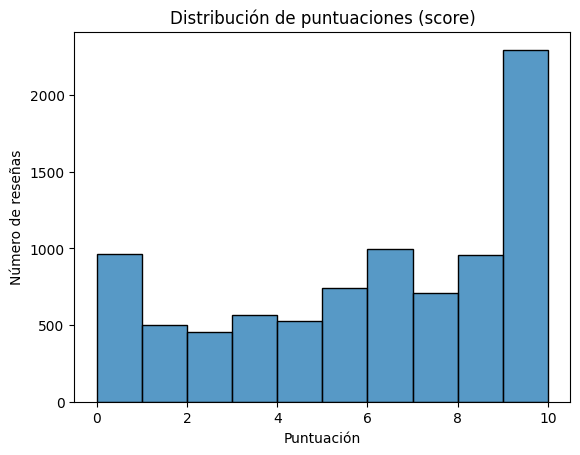

In [ ]:
sns.histplot(df['score'].astype(int), bins=10, kde=False)
plt.title('Distribución de puntuaciones (score)')
plt.xlabel('Puntuación')
plt.ylabel('Número de reseñas')
plt.show()


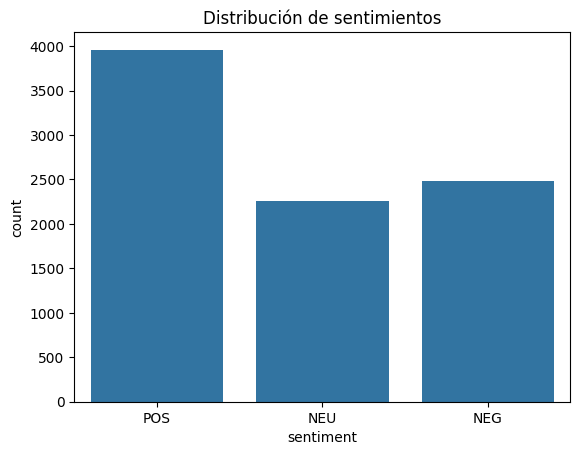

In [ ]:
sns.countplot(data=df, x='sentiment')
plt.title('Distribución de sentimientos')
plt.show()

## Extracción de características

In [ ]:
from sklearn.model_selection import train_test_split

# Separar para clasificación de sentimiento
X_train_sent, X_test_sent, y_train_sent, y_test_sent = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=42)

# Separar para predicción del score
X_train_score, X_test_score, y_train_score, y_test_score = train_test_split(
    df['review'], df['score'].astype(int), test_size=0.2, random_state=42)

In [ ]:
df['sentiment']

0       POS
3       POS
5       POS
6       POS
7       POS
       ... 
9948    NEG
9949    NEG
9950    NEG
9951    NEG
9952    NEG
Name: sentiment, Length: 8701, dtype: object

### Características Sparse

### TF-IDF

In [49]:
vectorizer = TfidfVectorizer()
vectorizer.fit(df['review'])

print("Número total de palabras únicas:", len(vectorizer.vocabulary_))

Número total de palabras únicas: 22835


In [50]:
# Ajustar vectorizador solo con los datos de entrenamiento
tfidf = TfidfVectorizer(max_features=1000)
X_train_sent_vec = tfidf.fit_transform(X_train_sent)
X_test_sent_vec = tfidf.transform(X_test_sent)

X_train_score_vec = tfidf.transform(X_train_score)
X_test_score_vec = tfidf.transform(X_test_score)

### Topic modelling

In [52]:
from sklearn.decomposition import NMF
from scipy.sparse import hstack  # Para concatenar sparse matrices

# Número de temas
n_topics = 20

# Topic modeling con NMF (solo sobre datos de entrenamiento)
nmf = NMF(n_components=n_topics, random_state=42)
W_train_sent = nmf.fit_transform(X_train_sent_vec)  # Representaciones temáticas del train
W_test_sent = nmf.transform(X_test_sent_vec)        # Proyección del test sobre esos mismos temas

W_train_score = nmf.transform(X_train_score_vec)
W_test_score = nmf.transform(X_test_score_vec)

# Concatenar los vectores TF-IDF con las representaciones de tópicos (W matrices)
X_train_sent_topic = hstack([X_train_sent_vec, W_train_sent])
X_test_sent_topic = hstack([X_test_sent_vec, W_test_sent])

X_train_score_topic = hstack([X_train_score_vec, W_train_score])
X_test_score_topic = hstack([X_test_score_vec, W_test_score])

In [ ]:
# Acceder al vocabulario
feature_names = tfidf.get_feature_names_out()

# Función para mostrar las top palabras por cada tópico
def display_topics(model, feature_names, no_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"🔹 Topic {topic_idx}: ", end='')
        top_features_idx = topic.argsort()[:-no_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_idx]
        print(", ".join(top_features))

# Mostrar los temas
display_topics(nmf, feature_names, no_top_words=10)

🔹 Topic 0: life, people, way, man, family, work, know, woman, real, world
🔹 Topic 1: movie, favorite, end, terrible, want, hate, review, understand, reason, critic
🔹 Topic 2: bad, awful, acting, horrible, terrible, effect, script, actor, act, thing
🔹 Topic 3: good, acting, pretty, year, actor, thing, opinion, recommend, job, need
🔹 Topic 4: great, decent, visual, voice, cast, job, awesome, acting, definitely, sound
🔹 Topic 5: film, certainly, scene, critic, find, overall, make, director, theme, original
🔹 Topic 6: story, animation, toy, tell, visual, acting, voice, decent, beautiful, pixar
🔹 Topic 7: watch, worth, recommend, interesting, fun, want, review, definitely, fan, minute
🔹 Topic 8: boring, long, slow, overrated, minute, hour, critic, stupid, oscar, predictable
🔹 Topic 9: like, feel, look, bit, people, try, thing, kind, play, tarantino
🔹 Topic 10: character, plot, main, interesting, development, care, feel, act, lack, dialogue
🔹 Topic 11: performance, amazing, beautiful, oscar,

### Características densas

#### Embedding preentrenado

In [ ]:
glove_file_path = './models/glove.twitter.27B.50d.txt'

# Crear un diccionario vacío para almacenar los embeddings
glove_dict = {}

# Leer el archivo y cargar los embeddings en el diccionario
with open(glove_file_path, 'r', encoding='utf-8') as f:
    for line in f:
        # Separar cada línea en la palabra y el vector
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_dict[word] = vector

# Verificar que se ha cargado correctamente el diccionario
print(f"Se han cargado {len(glove_dict)} palabras en el diccionario de GloVe.")

Se han cargado 1193514 palabras en el diccionario de GloVe.


In [ ]:
# Función para convertir una reseña en un vector
def text_to_vector(text, glove_dict, dim=50):
    words = text.split()  # Dividir la reseña en palabras (suponiendo que ya están limpias)

    # Obtener el vector de cada palabra si está en el diccionario de GloVe
    valid_vectors = [glove_dict[word] for word in words if word in glove_dict]

    # Si hay palabras válidas, calcular la media de sus vectores
    if valid_vectors:
        return np.mean(valid_vectors, axis=0)
    else:
        # Si no hay palabras válidas, devolver un vector de ceros
        return np.zeros(dim)

# Aplicar la función a cada reseña en el DataFrame
X_glove = np.vstack(df['review'].apply(lambda x: text_to_vector(x, glove_dict)))

# Verificar la forma de los vectores resultantes
print(X_glove.shape)

(8701, 50)


In [ ]:
# Para la tarea de clasificación de sentimiento
X_train_glove_sent, X_test_glove_sent, y_train_sent, y_test_sent = train_test_split(
    X_glove, df['sentiment'], test_size=0.2, random_state=42)

# Para la tarea de predicción del score
X_train_glove_score, X_test_glove_score, y_train_score, y_test_score = train_test_split(
    X_glove, df['score'].astype(int), test_size=0.2, random_state=42)

## Modelos

### TF-IDF + LR

In [53]:
le = LabelEncoder()
y_train_sent_enc = le.fit_transform(y_train_sent)
y_test_sent_enc = le.transform(y_test_sent)

modelLR = LogisticRegression(solver='liblinear')
#Entrenamos el modelo con el conjunto de train
modelLR.fit(X_train_sent_topic, y_train_sent_enc)
prediccion = modelLR.predict(X_test_sent_topic)


print(classification_report(y_test_sent_enc, prediccion, target_names=le.classes_))

              precision    recall  f1-score   support

         NEG       0.68      0.70      0.69       474
         NEU       0.57      0.32      0.41       487
         POS       0.71      0.89      0.79       779

    accuracy                           0.68      1740
   macro avg       0.65      0.64      0.63      1740
weighted avg       0.66      0.68      0.66      1740



In [54]:
import pandas as pd

# Crear un dataframe con las reseñas, verdaderas y predichas
errores_df = pd.DataFrame({
    'review': X_test_sent.tolist(),
    'true_label': le.inverse_transform(y_test_sent_enc),
    'predicted_label': le.inverse_transform(prediccion)
})

### TF-IDF + Topic Modeling (LSA) + LR

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 4. LSA - ajustar sobre el TF-IDF del train
lsa = TruncatedSVD(n_components=15, random_state=42)
X_train_topic = lsa.fit_transform(X_train_sent_vec)
X_test_topic = lsa.transform(X_test_sent_vec)

model = LogisticRegression(solver='liblinear')
model.fit(X_train_topic, y_train_sent_enc)

# 6. Predicción y evaluación
y_pred = model.predict(X_test_topic)
print(classification_report(y_test_sent_enc, y_pred, target_names=le.classes_))

#### Clasificación XGB

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# Codificar etiquetas
le = LabelEncoder()
y_train_sent_enc = le.fit_transform(y_train_sent)
y_test_sent_enc = le.transform(y_test_sent)

# Modelo XGBoost para clasificación multiclase
modelXGB = XGBClassifier(
    objective='multi:softprob',  # predice probas de varias clases
    num_class=len(le.classes_),  # número de clases
    eval_metric='mlogloss',      # métrica adecuada para multiclase
    use_label_encoder=False,
    random_state=42
)

# Entrenar modelo
modelXGB.fit(X_train_sent_topic, y_train_sent_enc)

# Predecir clases
prediccion = modelXGB.predict(X_test_sent_topic)

# Evaluar
print(classification_report(y_test_sent_enc, prediccion, target_names=le.classes_))

c:\Users\jugab\.conda\envs\master\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:40:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

         NEG       0.68      0.69      0.68       504
         NEU       0.50      0.36      0.42       463
         POS       0.72      0.83      0.77       774

    accuracy                           0.66      1741
   macro avg       0.63      0.62      0.62      1741
weighted avg       0.65      0.66      0.65      1741



### Embedding preentrenado + LR

In [ ]:
# Crear y entrenar el clasificador
modelLR = LogisticRegression(solver='liblinear')
modelLR.fit(X_train_glove_sent, y_train_sent_enc)

# Realizar predicciones
prediccion = modelLR.predict(X_test_glove_sent)

# Evaluar el modelo
print(classification_report(y_test_sent_enc, prediccion, target_names=le.classes_))

              precision    recall  f1-score   support

         NEG       0.64      0.69      0.66       504
         NEU       0.48      0.19      0.27       463
         POS       0.65      0.86      0.74       774

    accuracy                           0.63      1741
   macro avg       0.59      0.58      0.56      1741
weighted avg       0.60      0.63      0.59      1741



BERT

In [ ]:
# Separar para clasificación de sentimiento
X_train_sent, X_test_sent, y_train_sent, y_test_sent = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=42)

# Separar para predicción del score
X_train_score, X_test_score, y_train_score, y_test_score = train_test_split(
    df['review'], df['score'].astype(int), test_size=0.2, random_state=42)

In [ ]:
from sentence_transformers import SentenceTransformer

# Modelo multilingüe pequeño y rápido
model = SentenceTransformer('all-mpnet-base-v2')


# Aplicar BERT a tus textos de test
X_train_bert = model.encode(X_train_sent.tolist(), convert_to_numpy=True)
X_test_bert = model.encode(X_test_sent.tolist(), convert_to_numpy=True)

C:\Users\jugab\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
le = LabelEncoder()
y_train_sent_enc = le.fit_transform(y_train_sent)
y_test_sent_enc = le.transform(y_test_sent)

modelLR = LogisticRegression(solver='liblinear')
#Entrenamos el modelo con el conjunto de train
modelLR.fit(X_train_bert, y_train_sent_enc)
prediccion = modelLR.predict(X_test_bert)


print(classification_report(y_test_sent_enc, prediccion, target_names=le.classes_))

              precision    recall  f1-score   support

         NEG       0.69      0.71      0.70       504
         NEU       0.56      0.30      0.39       463
         POS       0.71      0.90      0.80       774

    accuracy                           0.68      1741
   macro avg       0.65      0.64      0.63      1741
weighted avg       0.66      0.68      0.66      1741



Con parámetro ``class_weight=balanced``

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf = LogisticRegression(class_weight='balanced', solver='liblinear')
clf.fit(X_train_bert, y_train_sent_enc)
y_pred = clf.predict(X_test_bert)

print(classification_report(y_test_sent_enc, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

         NEG       0.68      0.71      0.70       504
         NEU       0.52      0.39      0.44       463
         POS       0.75      0.84      0.79       774

    accuracy                           0.68      1741
   macro avg       0.65      0.65      0.64      1741
weighted avg       0.67      0.68      0.67      1741



## Modelo preentrenado

In [ ]:
from transformers import pipeline
from sklearn.metrics import classification_report
import numpy as np

# Carga la pipeline preentrenada
classifier = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

# Etiquetas originales del modelo y mapeo a tus etiquetas
model_to_custom_label = {
    "LABEL_0": "NEG",
    "LABEL_1": "NEU",
    "LABEL_2": "POS"
}

max_len = 512

def predecir_sentimiento(textos):
    textos_recortados = [t[:max_len] for t in textos]  # corta cada texto a max_len caracteres
    resultados = classifier(textos_recortados)
    etiquetas_pred = [model_to_custom_label[r['label']] for r in resultados]
    return etiquetas_pred


# Aplicar predicción al conjunto de test (X_test_sent es una Serie pandas)
y_pred = predecir_sentimiento(X_test_sent.tolist())

# Evaluar rendimiento
print(classification_report(y_test_sent, y_pred, digits=4))


Device set to use cuda:0


              precision    recall  f1-score   support

         NEG     0.6507    0.6603    0.6555       474
         NEU     0.3371    0.3655    0.3507       487
         POS     0.7045    0.6611    0.6821       779

    accuracy                         0.5782      1740
   macro avg     0.5641    0.5623    0.5628      1740
weighted avg     0.5870    0.5782    0.5821      1740



## Fine tuning

In [34]:
from datasets import Dataset

# Asegúrate de tener solo las columnas necesarias
hf_dataset = Dataset.from_pandas(df[['review', 'sentiment']])  # o 'score' si es lo que usas

In [35]:
from sklearn.preprocessing import LabelEncoder

label_enc = LabelEncoder()
df["label"] = label_enc.fit_transform(df["sentiment"])  # crea columna 'label' numérica

# Dataset para Hugging Face con la nueva columna
hf_dataset = Dataset.from_pandas(df[['review', 'label']])

In [36]:
hf_dataset = hf_dataset.train_test_split(test_size=0.2, seed=42)

In [37]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")

def tokenize_function(example):
    return tokenizer(example["review"], padding="max_length", truncation=True)

tokenized_datasets = hf_dataset.map(tokenize_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/6959 [00:00<?, ? examples/s]

Map:   0%|          | 0/1740 [00:00<?, ? examples/s]

In [38]:
from transformers import AutoModelForSequenceClassification

# Ajusta num_labels según tus clases (por ejemplo, 2 para positivo/negativo)
model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-cased", num_labels=len(set(df["label"])))

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.4 MB/s eta 0:00:00


In [40]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


In [41]:
!pip install -U transformers

In [42]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

<ipython-input-42-f68c0d1200e9>:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [43]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jopebrui (jopebrui-universitat-de-val-ncia) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,0.856900,0.777367,0.690805
2,0.646300,0.740449,0.714368


Epoch,Training Loss,Validation Loss,Accuracy
1,0.856900,0.777367,0.690805
2,0.646300,0.740449,0.714368
3,0.484500,0.791617,0.700575


TrainOutput(global_step=2610, training_loss=0.662545261894606, metrics={'train_runtime': 2130.7371, 'train_samples_per_second': 9.798, 'train_steps_per_second': 1.225, 'total_flos': 5493018821907456.0, 'train_loss': 0.662545261894606, 'epoch': 3.0})

In [44]:
trainer.save_model("sentiment-finetuned-movie-reviews")


In [45]:
# Realiza predicciones en el conjunto de test
predictions = trainer.predict(tokenized_datasets["test"])


In [ ]:
import numpy as np

y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids


In [47]:
from sklearn.metrics import classification_report

# Si usaste LabelEncoder antes para codificar etiquetas:
print(classification_report(y_true, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

         NEG       0.75      0.67      0.71       532
         NEU       0.47      0.58      0.52       428
         POS       0.83      0.78      0.81       780

    accuracy                           0.70      1740
   macro avg       0.68      0.68      0.68      1740
weighted avg       0.72      0.70      0.71      1740



### Análisis malas clasificaciones

In [55]:
# Analizamos errores

# Filtrar los errores donde la predicción no coincide con la realidad
errores_df = errores_df[errores_df['true_label'] != errores_df['predicted_label']]

# Filtrar solo los casos donde la etiqueta verdadera es NEU
errores_neu = errores_df[errores_df['true_label'] == 'NEU']

for _, row in errores_neu.sample(10, random_state=42).iterrows():
    print("-" * 80)
    print(f"REVIEW:\n{row['review']}\n")
    print(f"True label: {row['true_label']} | Predicted label: {row['predicted_label']}")

--------------------------------------------------------------------------------
REVIEW:
disappointed movie dialogue stupid rhythm movie slow people say movie perfect fail attempt homorromantic movie lay clichés high class lifestyle bore death apricot scene awkward disgusting soundtrack interesting

True label: NEU | Predicted label: NEG
--------------------------------------------------------------------------------
REVIEW:
spotlight attractive plot it´s grip portray controversial story people film classic it´ film doesn´t generate sensation fear danger threat moment remember memorable dialogue character development think film recieve praise it´s simplicity storytelling controversial aspect tom mccarthy brave didn´t direct memorable enjoyable film it´s dry joyless

True label: NEU | Predicted label: POS
--------------------------------------------------------------------------------
REVIEW:
give movie high score tarantino director high score

True label: NEU | Predicted label: NEG
---

Posibles explicaciones del error en la etiqueta:

- Etiquetado humano inconsistente o erróneo
Muchos datasets de texto etiquetados manualmente (como los de reseñas) sufren de inconsistencias. Una persona pudo haber considerado esa reseña como "neutral" por alguna razón subjetiva, aunque objetivamente parezca positiva.

- Etiquetado automático poco preciso
Si el dataset fue etiquetado automáticamente con otro modelo, puede haber errores sistemáticos.

- Frases ambiguas o irónicas
En frases muy breves, como esta, el etiquetador pudo interpretar falta de información emocional explícita y asignar un "NEU", aunque haya un tono implícitamente positivo.

### Eliminación de neutras

In [56]:
# Crear una copia del dataset original
df_sin_neu = df.copy()

# Eliminar las filas con sentimiento 'NEU'
df_sin_neu = df_sin_neu[df_sin_neu['sentiment'] != 'NEU']

In [57]:
# Separar para clasificación de sentimiento
X_train_sent2, X_test_sent2, y_train_sent2, y_test_sent2 = train_test_split(
    df_sin_neu['review'], df_sin_neu['sentiment'], test_size=0.2, random_state=42)

### TF-IDF + LR

In [58]:
# Ajustar vectorizador solo con los datos de entrenamiento
tfidf = TfidfVectorizer(max_features=1000)
X_train_sent_vec2 = tfidf.fit_transform(X_train_sent2)
X_test_sent_vec2 = tfidf.transform(X_test_sent2)

In [59]:
le = LabelEncoder()
y_train_sent_enc2 = le.fit_transform(y_train_sent2)
y_test_sent_enc2 = le.transform(y_test_sent2)

modelLR = LogisticRegression(solver='liblinear')
#Entrenamos el modelo con el conjunto de train
modelLR.fit(X_train_sent_vec2, y_train_sent_enc2)
prediccion = modelLR.predict(X_test_sent_vec2)


print(classification_report(y_test_sent_enc2, prediccion, target_names=le.classes_))

              precision    recall  f1-score   support

         NEG       0.87      0.76      0.81       490
         POS       0.86      0.93      0.90       799

    accuracy                           0.87      1289
   macro avg       0.87      0.84      0.85      1289
weighted avg       0.87      0.87      0.86      1289



## Recomendador

In [60]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"joanpb","key":"47d70c4d9eb30e10e7990596d38e0653"}'}

In [61]:
import os
import zipfile

# Crear carpeta oculta de Kaggle y mover el archivo ahí
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/

# Dar permisos adecuados
!chmod 600 /root/.kaggle/kaggle.json


In [62]:
!kaggle datasets download -d kashifsahil/16000-movies-1910-2024-metacritic


Dataset URL: https://www.kaggle.com/datasets/kashifsahil/16000-movies-1910-2024-metacritic
License(s): CC0-1.0
  0% 0.00/3.16M [00:00<?, ?B/s]
100% 3.16M/3.16M [00:00<00:00, 287MB/s]


In [63]:
with zipfile.ZipFile("16000-movies-1910-2024-metacritic.zip", "r") as zip_ref:
    zip_ref.extractall("metacritic_movies")


In [66]:
import os

os.listdir("metacritic_movies")


['16k_Movies.csv']

In [68]:
import pandas as pd

df_pelis = pd.read_csv("metacritic_movies/16k_Movies.csv")
df_pelis.head()


,Unnamed: 0,Title,Release Date,Description,Rating,No of Persons Voted,Directed by,Written by,Duration,Genres
0,0,Dekalog (1988),"Mar 22, 1996",This masterwork by Krzysztof Kieślowski is one...,7.4,118,Krzysztof Kieslowski,"Krzysztof Kieslowski, Krzysztof Piesiewicz",9 h 32 m,Drama
1,1,Three Colors: Red,"Nov 23, 1994",Krzysztof Kieslowski closes his Three Colors t...,8.3,241,Krzysztof Kieslowski,"Krzysztof Kieslowski, Krzysztof Piesiewicz, Ag...",1 h 39 m,"Drama,Mystery,Romance"
2,2,The Conformist,"Oct 22, 1970","Set in Rome in the 1930s, this re-release of B...",7.3,106,Bernardo Bertolucci,"Alberto Moravia, Bernardo Bertolucci",1 h 47 m,Drama
3,3,Tokyo Story,"Mar 13, 1972",Yasujiro Ozu’s Tokyo Story follows an aging co...,8.1,147,Yasujirô Ozu,"Kôgo Noda, Yasujirô Ozu",2 h 16 m,Drama
4,4,The Leopard (re-release),"Aug 13, 2004","Set in Sicily in 1860, Luchino Visconti's spec...",7.8,85,Luchino Visconti,"Giuseppe Tomasi di Lampedusa, Suso Cecchi D'Am...",3 h 7 m,"Drama,History"


In [128]:
# Ver cuántas veces aparece cada username
df['username'].value_counts()


,count
username,
JLuis_001,87
TVJerry,72
Brent_Marchant,70
LeZee,57
EpicLadySponge,51
...,...
fulci69wm,1
HPFANBOY1237,1
freeling10,1


In [126]:
# Hacemos un merge por las columnas que contienen el nombre de la película
movies_df = pd.merge(
    df[['movie']],
    df_pelis[['Title', 'Release Date', 'Rating','Genres']],
    left_on='movie',
    right_on='Title',
    how='inner'  # Solo conservar las que están en ambos
)

# Si no quieres quedarte con la columna 'Title' duplicada, puedes eliminarla
movies_df.drop(columns=['Title'], inplace=True)




In [127]:
movies_df

,movie,Release Date,Rating,Genres
0,Parasite,"Oct 11, 2019",8.7,"Drama,Thriller"
1,Parasite,"Oct 11, 2019",8.7,"Drama,Thriller"
2,Parasite,"Oct 11, 2019",8.7,"Drama,Thriller"
3,Parasite,"Oct 11, 2019",8.7,"Drama,Thriller"
4,Parasite,"Oct 11, 2019",8.7,"Drama,Thriller"
...,...,...,...,...
6065,Miss March,"Mar 13, 2009",4.3,"Comedy,Romance"
6066,Miss March,"Mar 13, 2009",4.3,"Comedy,Romance"
6067,Screwed,"May 12, 2000",7.9,"Comedy,Crime"
6068,Screwed,"May 12, 2000",7.9,"Comedy,Crime"


In [105]:
len(list(movies_df['movie'].unique()))

200

In [106]:
list(movies_df['movie'].unique())

['Parasite',
 'Roma',
 'I Am Not Your Negro',
 'Collective',
 'Carol',
 'Dunkirk',
 '45 Years',
 'The Irishman',
 'Faces Places',
 'Marriage Story',
 'La La Land',
 'Lady Bird',
 'Shoplifters',
 'Toni Erdmann',
 'Uncut Gems',
 'I Smile Back',
 'All Is True',
 'Champs',
 'Doctor Sleep',
 'Extraordinary Tales',
 'Sing',
 'Lizzie',
 'The Lovebirds',
 'Run All Night',
 'The Final Girls',
 'Cars 3',
 'The Dead Lands',
 'Morgan',
 'Being Charlie',
 'Crown Vic',
 'The Dressmaker',
 'Monster Hunter',
 'Midway',
 'Poltergeist',
 'Search Party',
 'Max Steel',
 'Home Sweet Hell',
 'Martyrs',
 'The Tax Collector',
 'Geostorm',
 'Dirty Grandpa',
 '211',
 'The Clapper',
 'Just Getting Started',
 'Reprisal',
 'Polar',
 'The Vanishing Of Sidney Hall',
 'The Fanatic',
 'The Ridiculous 6',
 'Crooked House',
 'The World Made Straight',
 '3 Generations',
 'A Family Man',
 'Accidental Love',
 'The Lovers',
 'Sherpa',
 'Spotlight',
 'The Florida Project',
 'Timbuktu',
 'Never Rarely Sometimes Always',
 'The

In [120]:
movies_df['Genres'] = movies_df.Genres.str.split(',')

In [121]:
# Copiar el dataframe
moviesWithGenres_df = movies_df.copy()

# Reemplazar NaN por listas vacías para poder iterar
moviesWithGenres_df['Genres'] = moviesWithGenres_df['Genres'].apply(lambda x: x if isinstance(x, list) else [])

# Crear columnas dummy por género
for index, row in moviesWithGenres_df.iterrows():
    for genre in row['Genres']:
        genre = genre.strip()
        if genre:
            moviesWithGenres_df.at[index, genre] = 1

# Rellenar NaNs con 0
moviesWithGenres_df = moviesWithGenres_df.fillna(0)

# Ver resultados
moviesWithGenres_df.head()


,movie,date,score,review,sentiment,Genres,Drama,Thriller,Documentary,History,...,Musical,Mystery,Sport,Fantasy,Horror,Animation,Family,Sci-Fi,Western,News
0,Parasite,"May 13, 2025",10,parasite masterclass direct screenwriting bong...,POS,"[Drama, Thriller]",1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Parasite,"May 4, 2025",10,bong joon ho masterpiece parasite deserve acco...,POS,"[Drama, Thriller]",1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Parasite,"Oct 6, 2024",10,godlike deserve praise question amazing story ...,POS,"[Drama, Thriller]",1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Parasite,"Sep 24, 2024",9,relatively simple low key racket spiral way co...,POS,"[Drama, Thriller]",1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Parasite,"Sep 3, 2024",9,amazing movie keep get crazy crazy end start e...,POS,"[Drama, Thriller]",1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [122]:
userInput = [

    {'movie':'Scary Movie 5', 'score':1},
    {'movie':'Toy Story', 'score':9},
    {'movie':'Ratatouille', 'score':8},
    {'movie':"Western", 'score':5},
    {'movie':'Paddington 2', 'score':7}
    ]

inputMovies = pd.DataFrame(userInput)
inputMovies

,movie,score
0,Scary Movie 5,1
1,Toy Story,9
2,Ratatouille,8
3,Western,5
4,Paddington 2,7


In [123]:
#Filtrar las películas por título

inputId = movies_df[movies_df['movie'].isin(inputMovies['movie'].tolist())]
#Luego juntarlas para obtener el movieId. Implícitamente, lo está uniendo por título.
inputMovies = pd.merge(inputId, inputMovies)
#Dataframe de entrada final
#Si una película que se agregó no se encuentra, entonces podría no estar en el dataframe
#original o podría estar escrito de otra forma (revisar mayúscula/minúscula).
inputMovies

,movie,date,score,review,sentiment,Genres
0,Paddington 2,"Mar 8, 2025",7,like entire paddington film pop book animation...,POS,"[Adventure, Comedy, Family]"
1,Paddington 2,"Jan 28, 2020",7,fantastic child movie good charming fun watch ...,POS,"[Adventure, Comedy, Family]"
2,Paddington 2,"May 31, 2018",7,watch expect hate pleasantly surprised,POS,"[Adventure, Comedy, Family]"
3,Paddington 2,"Mar 18, 2018",7,cute charming overall story paddington delive...,POS,"[Adventure, Comedy, Family]"
4,Scary Movie 5,"Feb 13, 2022",1,disney icon lindsay lohan ashley tisdale bad m...,NEG,[Comedy]
5,Scary Movie 5,"Aug 18, 2021",1,couple begin experience unusual activity bring...,NEG,[Comedy]
6,Scary Movie 5,"Aug 19, 2020",1,barrel term franchise joke fall flat idea wear...,NEG,[Comedy]
7,Scary Movie 5,"Feb 9, 2016",1,pretty sum scary movie far unoriginal parody s...,NEG,[Comedy]
8,Scary Movie 5,"Apr 20, 2014",1,scary movie time new far bad know bad funny ha...,NEG,[Comedy]
9,Scary Movie 5,"Jul 31, 2013",1,get good see snoop bad movie like effort laugh...,NEG,[Comedy]
